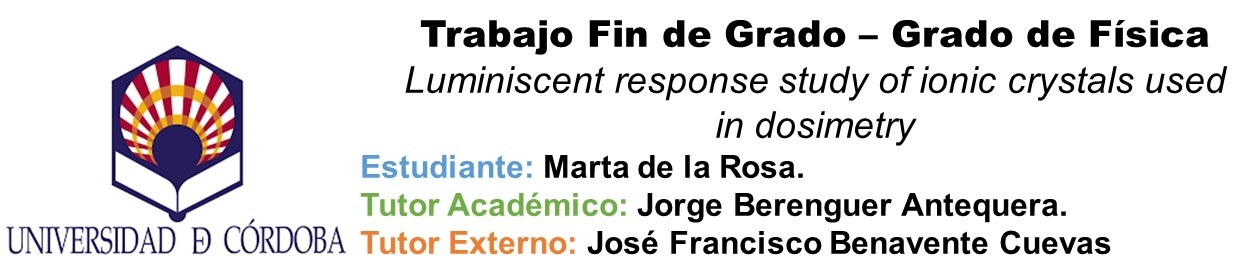

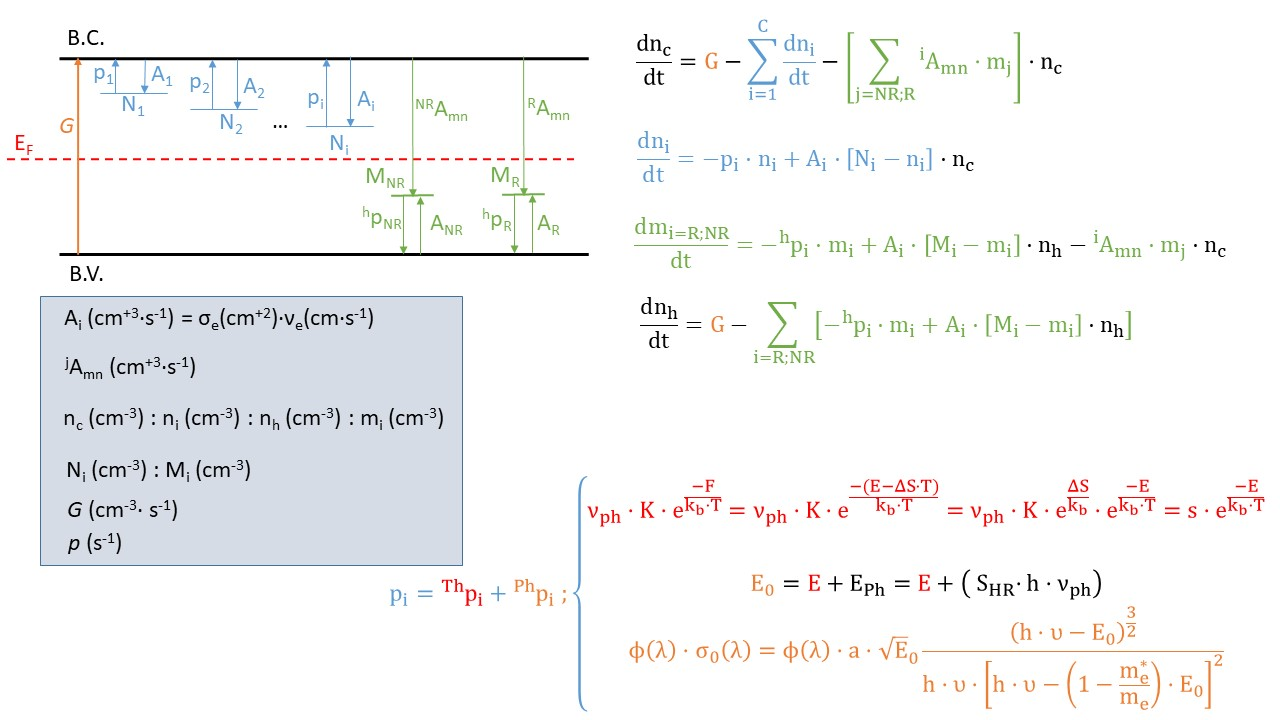

# LiF: Mg; Ti

In [7]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## 1. Importing data

In [8]:
## STRUCTURAL PARAMETERS

PathStructural = 'Simulations/ParametrosEstructurales.xlsx'
StructuralData = pd.read_excel(PathStructural, sheet_name='Hoja1', header=0, usecols=None, nrows=None)

N = [StructuralData.iloc[i, 0] for i in range(6)]                          # Total density of available positions for trap i (cm-3)
M_R, M_NR = StructuralData.iloc[0, 1], StructuralData.iloc[0, 2]           # Total density of available positions for radiative/non readiative recomb. centers (cm-3)
N_I, N_II, N_III, N_IV, N_V, N_s = N

A = [StructuralData.iloc[i, 3] for i in range(6)]                          # Electron trapping probability factor for trap i (cm3/s)
A_NR, A_R = StructuralData.iloc[0, 6], StructuralData.iloc[0, 7]           # Hole trapping probability factor for radiative/non radiative recomb. centers (cm3/s)
A_mn_NR, A_mn_R = StructuralData.iloc[0, 4], StructuralData.iloc[0, 5]     # Electron-hole trapping probability factor for radiative/non radiative recomb. centers (cm3/s)
A_I, A_II, A_III, A_IV, A_V, A_s = A


## CINETIC PARAMETERS

PathCinetics = 'Simulations/ParametrosCineticos.xlsx'
CineticsData = pd.read_excel(PathCinetics, sheet_name='Hoja1', header=0, usecols=None, nrows=None)


E = [CineticsData.iloc[i, 0] for i in range(6)]                            # Activation energy for trap i (eV)
E_R_h, E_NR_h = CineticsData.iloc[0, 2], CineticsData.iloc[0, 4]           # Activation energy for radiative/ non radiative recombination centers (eV)
E_I, E_II, E_III, E_IV, E_V, E_s = E

S = [CineticsData.iloc[i, 1] for i in range(6)]                            # Frequency factor for trap i (s-1)
S_R_h, S_NR_h = CineticsData.iloc[0, 3], CineticsData.iloc[0, 5]           # Frequency factor for radiative/ non radiative recombination centers (s-1)
S_I, S_II, S_III, S_IV, S_V, S_s = S


## 2. Electron-hole pair generation factor study

## 3. The Frequency Factor

#### 3.1 Original formula
$S = \nu_{ph} ~ K ~ e^{\frac{\Delta S}{k_B}}$

where:
- $\nu_{ph}$: lattice phonon vibration frequency
- $K$: transition probability constant
- $\Delta S$: entropy change associated with the transition

#### 3.2 First variant (p.25 McKeever)
$ \\s = N_c ~\nu_e ~\sigma $

where:
- $N_c$: concentration of available states in the conduction band (m-3)
- $\nu_e$: thermal velocity of free electrons (ms-1)
- $\sigma$: capture cross-section for the trap (m2)

#### 3.3 Second variant (common, no reference)
$ s = \nu \approx \frac{k_B ~T}{h}$ 

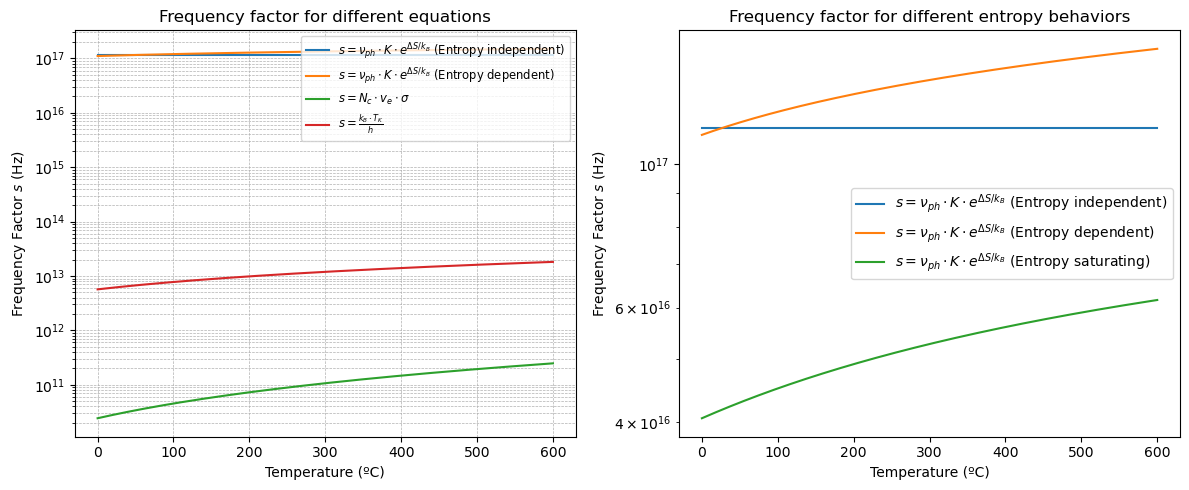

In [54]:
# Range of temperatures
T_C = np.linspace(0, 600, 500)  
T_K = T_C + 273.15  # Convert to Kelvin


def sfactor_original(delta_S):
    
    # Calculates the frequency factor following:
    #       s = nu * K * exp(Delta S / kB)
    #
    # nu: lattice phonon vibration frequency
    # K: transition probability constant
    # Delta S: entropy change
    # kB: Boltzmann constant (eV/K)
    
    K = 9.39e+02                 # from 'other_plots.ipynb'
    nu_m = 90000                 # from the Bransden book (m-1)
    nu_s = 2.9979e8 * nu_m       # (s-1)
    
    s_original = nu_s * K * np.exp(delta_S / kB)
    return s_original

def sfactor_availablestates(T_K, m_eff):
    
    # Calculates the frequency factor following:
    #       s = Nc * v_e * sigma
    #
    # Nc: density of available states (m-3)
    # v_e: thermal velocity of free electrons (m/s)
    # sigma: capture cross section of the trap (m2)
    
    k_B = 1.380649e-23       # Boltzmann constant in J/K
    h = 6.62607015e-34       # Planck constant in J·s
    
    Nc = 2 * ((2 * np.pi * m_eff * k_B * T_K) / h**2)**(3/2)
    v_e = np.sqrt(3 * k_B * T_K / m_eff)
    sigma = 1e-20
    
    s_available_states = Nc * v_e * sigma
    return s_available_states

def sfactor_common(T_K):
    # Calculates the frequency factor following:
    #       s = k_B * T_K / h
    
    k_B = 8.617333262145e-5      # Boltzmann (eV/K)
    h = 4.1357e-15               # Planck's constant (eV.s)
    
    s_common = k_B * T_K / h
    return s_common


## 3.1
# Entropy independent to temperature change
kB = 8.617333262145e-5  # Boltzmann constant (eV/K)
delta_S_indep = 1.5 * kB  # entropy change (approximate value)

s_entropy_indep = sfactor_original(delta_S_indep)
s_entropy_indep = np.full_like(T_C, s_entropy_indep)

# Entropy dependent on temperature change
alpha = (1.5 * kB) / np.log(300)
delta_S_logT= alpha * np.log(T_K)

s_entropy_dep = sfactor_original(delta_S_logT)

# Entropy with the SATURATING MODEL 
#       \Delta S = \Delta S_max · T / (T + T0)
# where
# - \Delta S_max = maximum entropy change
# - T0 = temperature where stauration effects become important

delta_S_max = 1.5 * kB
T0 = 600                    # K 
delta_S_sat = delta_S_max * T_K / (T_K + T0)
s_entropy_sat = sfactor_original(delta_S_sat)



## 3.2
me = 9.10938356e-31  # electron mass (kg)
m_eff = me
s_available_states = sfactor_availablestates(T_K, m_eff)

## 3.3
s_common = sfactor_common(T_K)


# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(T_C, s_entropy_indep, label=r'$s = \nu_{ph} \cdot K \cdot e^{\Delta S / k_B}$ (Entropy independent)')
plt.plot(T_C, s_entropy_dep, label=r'$s = \nu_{ph} \cdot K \cdot e^{\Delta S / k_B}$ (Entropy dependent)')
plt.plot(T_C, s_available_states, label=r'$s = N_c \cdot v_e \cdot \sigma$')
plt.plot(T_C, s_common, label=r'$s = \frac{k_B \cdot T_K}{h}$')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Frequency Factor $s$ (Hz)')
plt.title('Frequency factor for different equations')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc = 'upper right', fontsize = 'small')

plt.subplot(1, 2, 2)
plt.plot(T_C, s_entropy_indep, label=r'$s = \nu_{ph} \cdot K \cdot e^{\Delta S / k_B}$ (Entropy independent)')
plt.plot(T_C, s_entropy_dep, label=r'$s = \nu_{ph} \cdot K \cdot e^{\Delta S / k_B}$ (Entropy dependent)')
plt.plot(T_C, s_entropy_sat, label=r'$s = \nu_{ph} \cdot K \cdot e^{\Delta S / k_B}$ (Entropy saturating)')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Frequency Factor $s$ (Hz)')
plt.yscale('log')
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.title('Frequency factor for different entropy behaviors')
plt.tight_layout()
plt.show()


## 4. Differential Equations System

Let's redefine the Frequency Factor values for the traps.

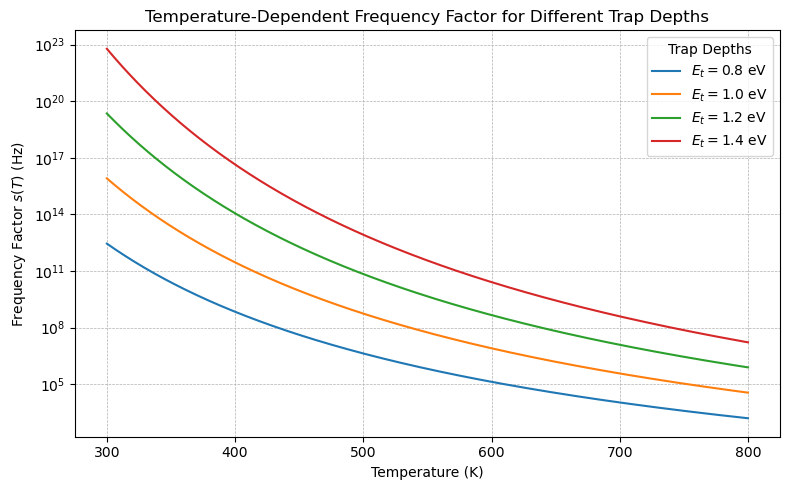

In [ ]:
# Constants
kB = 8.617e-5  # eV/K

def diff_equations(y0, t):
    
    # Define the differential equations for the system for a given set of initial parameters.
    # Such equations are:
    #     dn_c/dt = G  -  \sum_i dn_i/dt  +  (\sum_R,NR A_mn_i * m_i) * n_c
    #
    #     dn_i/dt = -p_i * n_i + A_i * (N_i - n_i) * n_c
    #     G: Energy gap (eV)
    #     p_i: probability of capture for trap i (cm3/s) = S * exp(-E_i/kB T)
    #     n_i: electron density of trap i (cm-3)
    #     A_i: electron trapping probability factor for trap i (cm3/s)
    #     N_i: total density of available positions for trap i (cm-3)
    #     n_c: electron density in conduction band (cm-3)
    #     A_mn_i: electron-hole trapping probability factor for radiative/non radiative recombination centers (cm3/s)
    #     m_i: hole density for radiative/non radiative recombination center (cm-3)
    #     
    #     dn_h/dt = G  -  \sum_R,NR - p_h_i * m_i + A_h_i * (M_i - m_i) * n_c
    #     
    #     i = {R, NR}
    #     p_h_i: probability of capture for radiative/non radiative center (cm3/s) = S * exp(-E_i/kB T)
    #     m_i: hole density for radiative/non radiative center (cm-3)
    #     A_h_i: hole trapping probability factor for radiative/non radiative center (cm3/s)
    #     M_i: total density of available positions for radiative/non radiative center (cm-3)
    #     m_i: hole density for radiative/non radiative center (cm-3)
    #     n_h: hole density in valence band (cm-3)
    
    # Unpack the variables
    n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = y0
    
    # Define the temperature change T with the heating rate hr in a time t
    T = 273.15 + T_C + hr * t
    
    # Calculate the probabilities of capture
    p_I = S_I * np.exp(-E_I / (kB * T))
    p_II = S_II * np.exp(-E_II / (kB * T))
    p_III = S_III * np.exp(-E_III / (kB * T))
    p_IV = S_IV * np.exp(-E_IV / (kB * T))
    p_V = S_V * np.exp(-E_V / (kB * T))
    p_s = S_s * np.exp(-E_s / (kB * T))
    
    p_R_h = S_R_h * np.exp(-E_R_h / (kB * T))
    p_NR_h = S_NR_h * np.exp(-E_NR_h / (kB * T))
    
    # Calculate the rates of change for each variable
    dn_I = - p_I * n_I + A_I * (N_I - n_I) * n_c
    dn_II = - p_II * n_II + A_II * (N_II - n_II) * n_c
    dn_III = - p_III * n_III + A_III * (N_III - n_III) * n_c
    dn_IV = - p_IV * n_IV + A_IV * (N_IV - n_IV) * n_c
    dn_V = - p_V * n_V + A_V * (N_V - n_V) * n_c
    dn_s = - p_s * n_s + A_s * (N_s - n_s) * n_c
    
    #dm_R = - m_R * p_R_h + A_R * (M_R - m_R) * n_v - A_mn_R * m_R * n_c
    #dm_NR = - m_NR * p_NR_h + A_NR * (M_NR - m_NR) * n_v - A_mn_NR * m_NR * n_c
    dm_R = - m_R * A_mn_R * n_c + A_R * (M_R - m_R) * n_v - p_R_h * m_R
    dm_NR = - m_NR * A_mn_NR* n_c + A_NR * (M_NR - m_NR) * n_v - p_NR_h * m_NR
    
    # Rate of change of the electron density in the conduction and valence band
    dn_c = G - (dn_I + dn_II + dn_III + dn_IV + dn_V + dn_s) - (A_mn_R * m_R + A_mn_NR * m_NR) * n_c
    dn_v = G + p_R_h * m_R + p_NR_h * m_NR - (A_R * (M_R - m_R) + A_R * (M_NR - m_NR)) * n_v
    
    return dn_I, dn_II, dn_III, dn_IV, dn_V, dn_s, dm_R, dm_NR, dn_c, dn_v
    

### 4.1 Irradiation

There's no heating (`hr = 0`). The temperature is set at 25ºC and `f = 1000`

/var/folders/_c/s9xtx7kn61l5wvpw4pyjsc8c0000gn/T/ipykernel_41258/4246134951.py:53: RuntimeWarning: invalid value encountered in divide
  plt.plot(t, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR))


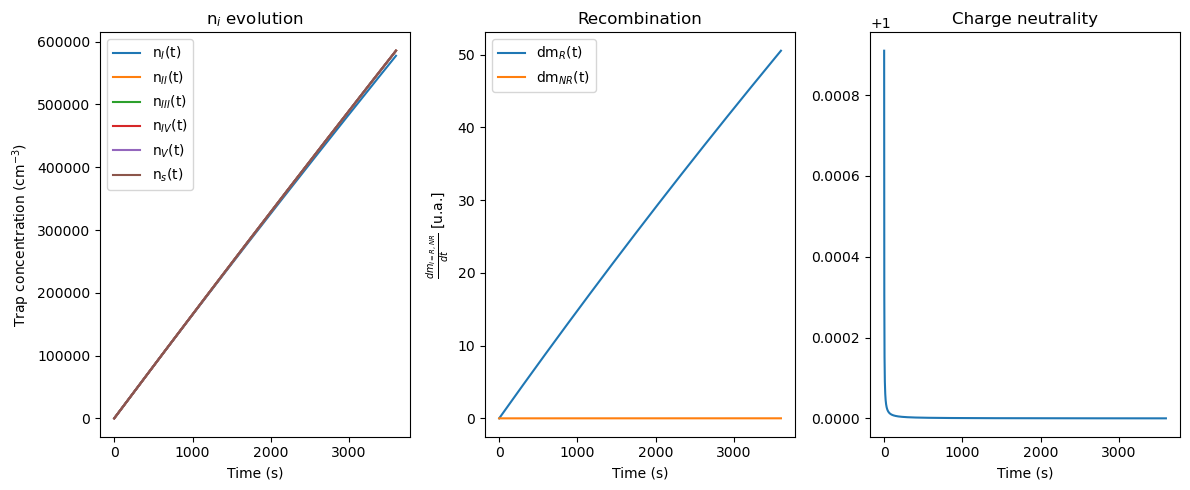

In [ ]:
# Parameters for IRRADIATION

T_C = 25             # Temperature (ºC)
hr = 0               # Heating rate (ºC/s)
G = 1000             # ????? Electron-hole pair generation (cm-3 s-1)

# Initial conditions
n_0 = 0 * np.ones(6)           # Initial concentration of traps (cm-3)
m_R_0, m_NR_0 = 0, 0           # Initial concentration of radiative/non radiative recombination centers (cm-3)
n_c_0, n_v_0 = 0,0             # Initial concentration of ???

# Time vector (s)
npoints = 3600
t = np.linspace(0, npoints-1, npoints)

# Initial conditions vector
y0 = np.concatenate((n_0, [m_R_0, m_NR_0, n_c_0, n_v_0]))

# Solve the differential equations and extract the results
solution_irradiation = odeint(diff_equations, y0, t)
n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = solution_irradiation.T


# Plotting the results for every energy value

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(t, n_I, label='n$_{I}$(t)')
plt.plot(t, n_II, label='n$_{II}$(t)')
plt.plot(t, n_III, label='n$_{III}$(t)')
plt.plot(t, n_IV, label='n$_{IV}$(t)')
plt.plot(t, n_V, label='n$_{V}$(t)')
plt.plot(t, n_s, label='n$_{s}$(t)')

plt.xlabel('Time (s)')
plt.ylabel('Trap concentration (cm$^{-3}$)')
plt.title('n$_{i}$ evolution')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 2)
dm_R = m_R * A_mn_R * n_c
dm_NR = m_NR * A_mn_NR * n_c
plt.plot(t, dm_R, label='dm$_{R}$(t)')
plt.plot(t, dm_NR, label='dm$_{NR}$(t)')

plt.xlabel('Time (s)')
plt.ylabel(r'$\frac{dm_{i=R,NR}}{dt}$ [u.a.]')
plt.title('Recombination')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 3)
plt.plot(t, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR))
plt.xlabel('Time (s)')
plt.title('Charge neutrality')

plt.tight_layout()
plt.show()




### 4.2 Relaxation

There's no heating (`h=0`) and there's no generation of electron-hole pairs (`hr=0`). The temperature is set at 25ºC

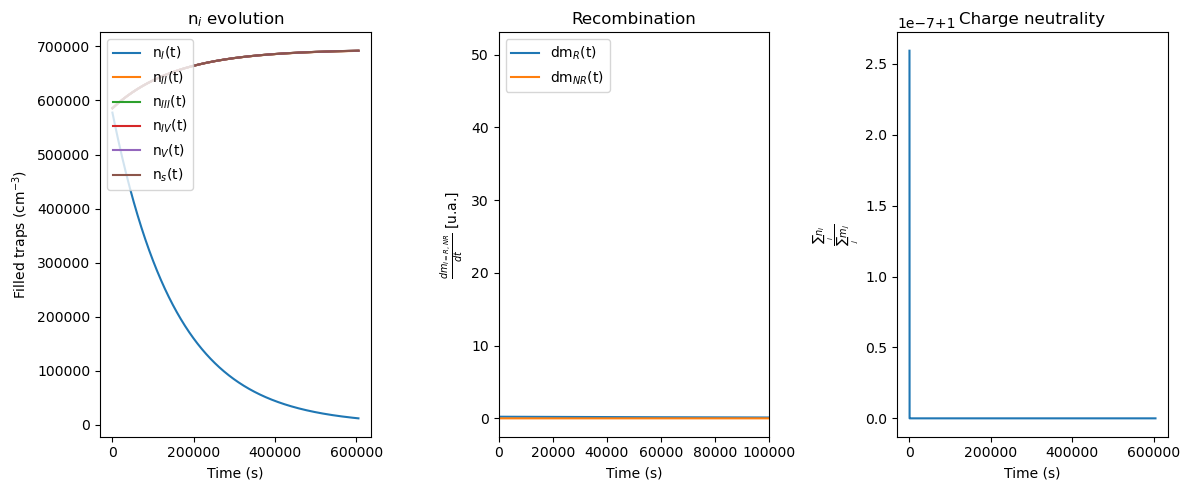

In [ ]:
# Parameters for RELAXATION
T_C = 25             # Temperature (ºC)
hr = 0               # Heating rate (ºC/s)
G = 0                # ????? Electron-hole pair generation (cm-3 s-1)

# Initial conditions
n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0, m_NR_0,m_R_0,n_c_0,n_v_0=n_I[-1],n_II[-1],n_III[-1],n_IV[-1],n_V[-1],n_s[-1],m_R[-1],m_NR[-1],n_c[-1], n_v[-1]
y0 = [n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0, m_NR_0,m_R_0,n_c_0,n_v_0]

# Time vector (s)
npoints = 3600 * 24 * 7
t = np.linspace(0, npoints-1, npoints)

# Solve the differential equations and extract the results
solution_relaxation = odeint(diff_equations, y0, t)
n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = solution_relaxation.T

# Plotting the results for every energy value
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(t, n_I, label='n$_{I}$(t)')
plt.plot(t, n_II, label='n$_{II}$(t)')
plt.plot(t, n_III, label='n$_{III}$(t)')
plt.plot(t, n_IV, label='n$_{IV}$(t)')
plt.plot(t, n_V, label='n$_{V}$(t)')
plt.plot(t, n_s, label='n$_{s}$(t)')

plt.xlabel('Time (s)')
plt.ylabel('Filled traps (cm$^{-3}$)')
plt.title('n$_{i}$ evolution')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 2)
dm_R = m_R * A_mn_R * n_c
dm_NR = m_NR * A_mn_NR * n_c
plt.plot(t, dm_R, label='dm$_{R}$(t)')
plt.plot(t, dm_NR, label='dm$_{NR}$(t)')

plt.xlabel('Time (s)')
plt.ylabel(r'$\frac{dm_{i=R,NR}}{dt}$ [u.a.]')
plt.title('Recombination')
plt.legend(loc = 'upper left')
plt.xlim(0, 100000)

plt.subplot(1, 3, 3)
plt.plot(t, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR + 0.0))
plt.xlabel('Time (s)')
plt.ylabel(r'$\frac{\sum_i n_i}{\sum_j m_j}$')
plt.title('Charge neutrality')

plt.tight_layout()
plt.show()

### 4.3 Heating

Now the heating rate goes at `hr = 1.0`K/s, and the initial temperature is set at 0ºC. 

** The `f = 0` still??

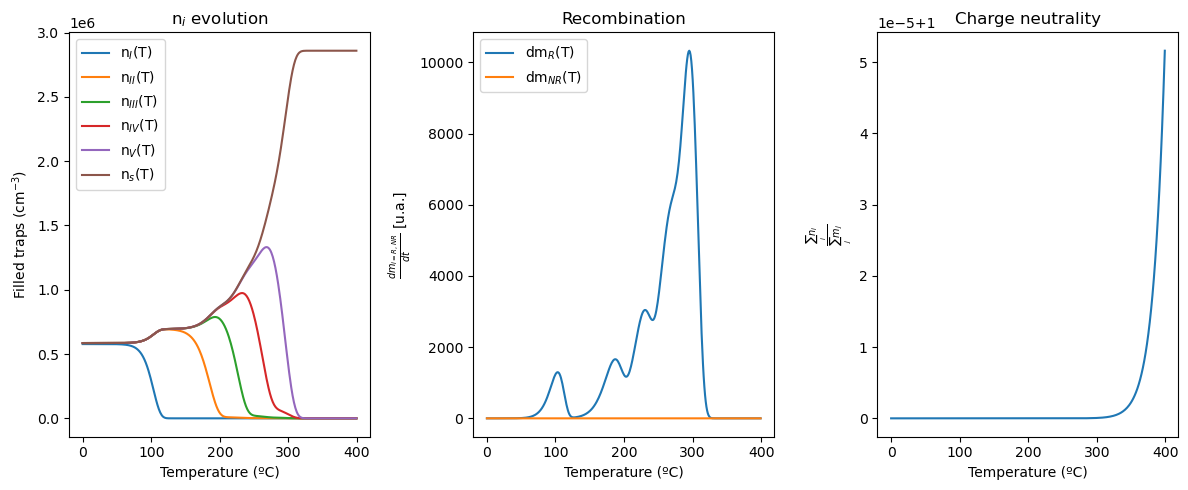

In [ ]:
# Parameters for HEATING
T_C = 0              # Temperature (ºC)
hr = 1.0             # Heating rate (ºC/s)
G = 0                # ????? Electron-hole pair generation (cm-3 s-1)


# Initial conditions
n_I_0, n_II_0, n_III_0, n_IV_0, n_V_0, n_s_0, m_NR_0, m_R_0, n_c_0, n_v_0 = n_I[1],n_II[1],n_III[1],n_IV[1],n_V[1],n_s[1],m_R[1],m_NR[1],n_c[1], n_v[1] 
y0 = [n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0, m_NR_0,m_R_0,n_c_0,n_v_0]

# Time vector (s)
npoints = 400
t = np.linspace(0, npoints-1, npoints)

# Solve the differential equations and extract the results
solution_irradiation = odeint(diff_equations, y0, t)
n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = solution_irradiation.T

# Plotting the results for every energy value
temperature = t * hr + T_C
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(temperature, n_I, label='n$_{I}$(T)')
plt.plot(temperature, n_II, label='n$_{II}$(T)')
plt.plot(temperature, n_III, label='n$_{III}$(T)')
plt.plot(temperature, n_IV, label='n$_{IV}$(T)')
plt.plot(temperature, n_V, label='n$_{V}$(T)')
plt.plot(temperature, n_s, label='n$_{s}$(T)')

plt.xlabel('Temperature (ºC)')
plt.ylabel('Filled traps (cm$^{-3}$)')
plt.title('n$_{i}$ evolution')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 2)
dm_R = m_R * A_mn_R * n_c
dm_NR = m_NR * A_mn_NR * n_c
plt.plot(temperature, dm_R, label='dm$_{R}$(T)')
plt.plot(temperature, dm_NR, label='dm$_{NR}$(T)')
plt.xlabel('Temperature (ºC)')
plt.ylabel(r'$\frac{dm_{i=R,NR}}{dt}$ [u.a.]')
plt.title('Recombination')
plt.legend(loc = 'upper left')

plt.subplot(1, 3, 3)
plt.plot(t, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR))
plt.xlabel('Temperature (ºC)')
plt.ylabel(r'$\frac{\sum_i n_i}{\sum_j m_j}$')
plt.title('Charge neutrality')

plt.tight_layout()
plt.show()
